## 一、使用一个预训练模型

通过本脚本，我们将学习如何使用 `pyannote.audio` 模型处理一个经过人为注释的音频文件。

In [1]:
# preparing notebook for visualization purposes
# (only show outputs between t=0s and t=30s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)

In [2]:
# 首先克隆pyannote-audio Github仓库到本地，并将其根目录赋值给ROOT_DIR变量
ROOT_DIR = "/home/liang/GitHub/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"

<class 'pyannote.core.annotation.Annotation'>
[ 00:00:06.690 -->  00:00:07.120] 0 speaker90
[ 00:00:07.550 -->  00:00:08.350] 1 speaker91
[ 00:00:08.320 -->  00:00:10.020] 2 speaker90
[ 00:00:09.920 -->  00:00:11.030] 3 speaker91
[ 00:00:10.570 -->  00:00:14.700] 4 speaker90
[ 00:00:14.490 -->  00:00:17.920] 5 speaker91
[ 00:00:18.050 -->  00:00:21.490] 6 speaker90
[ 00:00:18.150 -->  00:00:18.590] 7 speaker91
[ 00:00:21.780 -->  00:00:28.500] 8 speaker91
[ 00:00:27.850 -->  00:00:30.000] 9 speaker90


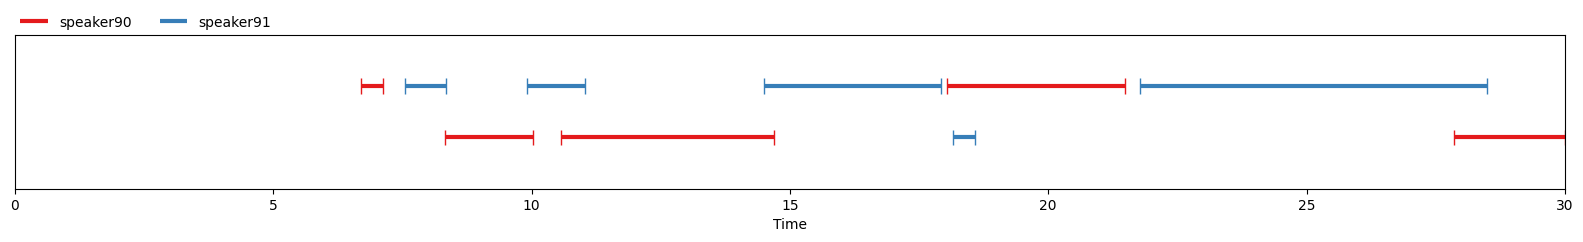

In [5]:
from pyannote.database.util import load_rttm

REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"
reference = load_rttm(REFERENCE)["sample"]
print(type(reference))
print(reference)

reference

### 1、从Huggingface Model Hub载入模型

预训练好的模型可以在[Huggingface Model Hub](https://huggingface.co/models?other=pyannote-audio-model)上下载。

In [6]:
from huggingface_hub import HfApi
available_models = [m.modelId for m in HfApi().list_models(filter="pyannote-audio-model")]
available_models

['pyannote/segmentation',
 'pyannote/embedding',
 'pyannote/TestModelForContinuousIntegration']

下面载入扬声器分段模型`pyannote/segmentation`

In [7]:
from pyannote.audio import Model

model = Model.from_pretrained("pyannote/segmentation")

/home/liang/miniconda3/envs/pyannote/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 17.7M/17.7M [00:05<00:00, 3.50MB/s]
Downloading: 100%|██████████| 318/318 [00:00<00:00, 141kB/s]


... which consists in SincNet feature extraction (`sincnet`) , LSTM sequence modeling (`lstm`), a few feed-forward layers (`linear`), and a final multi-label `classifier`:

上面下载的 `pyannote/segmentation` 模型包括如下内容：

- `SincNet`特征提取网络（`sincnet`）
- `LSTM` 序列模型（`lstm`）
- 一些前向传播层（`linear`）
- 最终的多标签信息`classifier`

In [8]:
model.summarize()

  | Name       | Type       | Params | In sizes      | Out sizes                                  
--------------------------------------------------------------------------------------------------------
0 | sincnet    | SincNet    | 42.6 K | [3, 1, 32000] | [3, 60, 115]                               
1 | lstm       | LSTM       | 1.4 M  | [3, 115, 60]  | [[3, 115, 256], [[8, 3, 128], [8, 3, 128]]]
2 | linear     | ModuleList | 49.4 K | ?             | ?                                          
3 | classifier | Linear     | 387    | [3, 115, 128] | [3, 115, 3]                                
4 | activation | Sigmoid    | 0      | [3, 115, 3]   | [3, 115, 3]                                
--------------------------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.891     Total estimated model params size (MB)

更多`model`相关详细信息，可以通过其类属性`specifications`查看

In [9]:
specs = model.specifications
specs

Specifications(problem=<Problem.MULTI_LABEL_CLASSIFICATION: 2>, resolution=<Resolution.FRAME: 1>, duration=5.0, warm_up=(0.0, 0.0), classes=['speaker#1', 'speaker#2', 'speaker#3'], permutation_invariant=True)

其中：

- `duration = 0.5`：表示模型接收一个`5s`的音频块
- `Resolution.FRAME` and `len(classes) == 4`: the model output a sequence of frame-wise 4-dimensoinal scores
- `Problem.MULTI_LABEL_CLASSIFICATION` for each frame, more than one speaker can be active at once

To apply the model on the audio file, we wrap it into an `Inference` instance:

为了将模型应用于音频文件，我们将其封装到一个 `Inference` 实例：

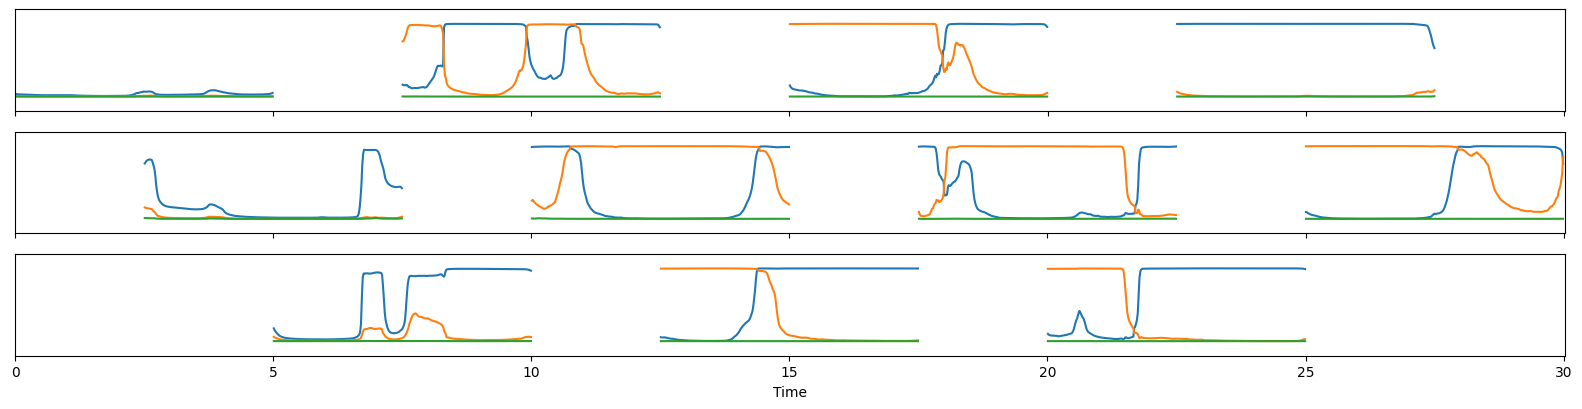

In [10]:
from pyannote.audio import Inference
inference = Inference(model, step=2.5)
output = inference(AUDIO_FILE)
output

For each of the 11 positions of the 5s window, the model outputs a 4-dimensional vector every 16ms (293 frames for 5 seconds), corresponding to the probabilities that each of (up to) 4 speakers is active.

对于5s窗口的11个位置中的每一个，模型每16ms（293帧，5秒）输出一个4维向量，对应于（最多）4个扬声器活动的概率。

In [12]:
# 查看output的数据类型
print("Inference的输出output的数据：", type(output))

# 查看output的数据形状
print("Inference的输出output的数据形状：", output.data.shape)

Inference的输出output的数据： <class 'pyannote.core.feature.SlidingWindowFeature'>
Inference的输出output的数据形状： (11, 293, 3)


### 3、从内存中处理一个文件

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary.

当音频文件不是存储在磁盘中的文件时，pipelines 同样可以处理表示为 `{"waveform": ..., "sample_rate": ...}` 字典数据格式的音频。

In [13]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


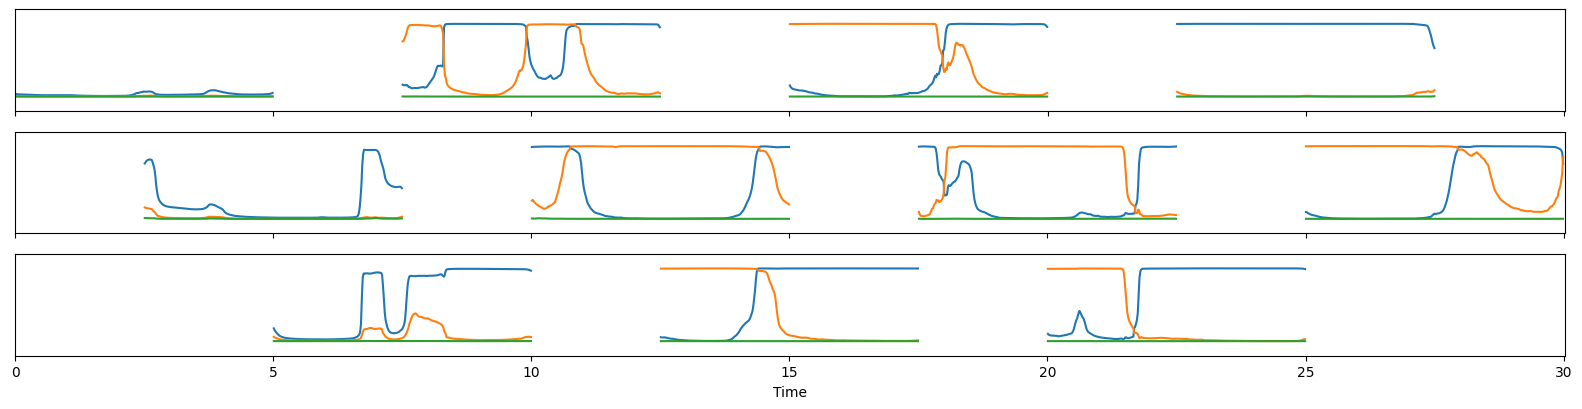

In [14]:
output = inference(audio_in_memory)
output

### 3、处理文件部分内容

If needed, `Inference` can be used to process only part of a file:

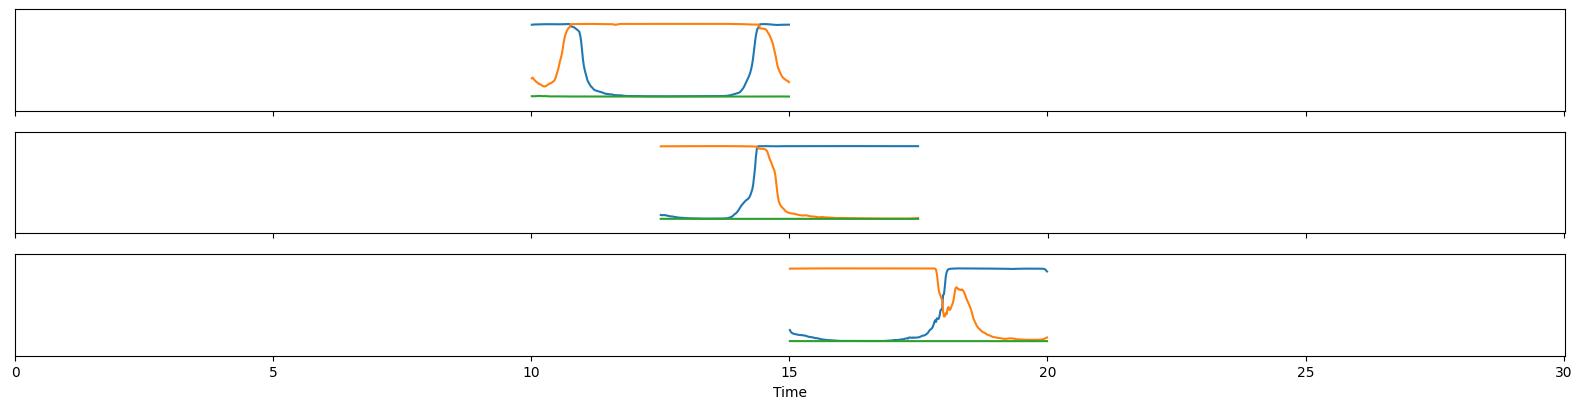

In [16]:
from pyannote.core import Segment

output = inference.crop(AUDIO_FILE, Segment(10, 20))
output